In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.integrate import odeint
from copy import deepcopy
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import scipy
%matplotlib inline

# Determine growth rate of oral and gut bacteria

In [2]:
df_oral_taxa = pd.read_csv("../../databases/fHOMD/oral_typical_species.csv")
df_oral_taxa.head()

,taxon,MeanRelabunOral,PrevalenceOral,MeanRelabunGut,PrevalenceGut,species,species_binomial
0,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.550773,0.458484,0.000039,0.009404,Actinobaculum_sp_oral_taxon_183,Actinobaculum sp
1,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.143748,0.395307,0.000021,0.009404,Actinomyces_johnsonii,Actinomyces johnsonii
2,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.354643,0.402527,0.000000,0.000000,Actinomyces_massiliensis,Actinomyces massiliensis
3,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.505413,0.635379,0.000074,0.018809,Actinomyces_naeslundii,Actinomyces naeslundii
4,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,0.127484,0.500000,0.000110,0.034483,Actinomyces_sp_S6_Spd3,Actinomyces sp


In [3]:
df_growth = pd.read_csv("tbl_max_growth.csv")
df_growth = df_growth[df_growth.medium=="AGORA_WD"]
df_growth['species_binomial'] = [(' ').join(x.split('_')[0:2]) for x in df_growth.agoraid]
df_growth['is_oral'] = ['Yes' if x in list(df_oral_taxa.species_binomial) else 'No' for x in df_growth.species_binomial]
df_growth.head()

,agoraid,max_growth_rate,medium,species_binomial,is_oral
4908,Abiotrophia_defectiva_ATCC_49176,0.229485,AGORA_WD,Abiotrophia defectiva,No
4909,Achromobacter_xylosoxidans_A8,0.402918,AGORA_WD,Achromobacter xylosoxidans,No
4910,Achromobacter_xylosoxidans_NBRC_15126,0.217327,AGORA_WD,Achromobacter xylosoxidans,No
4911,Acidaminococcus_fermentans_DSM_20731,0.200883,AGORA_WD,Acidaminococcus fermentans,No
4912,Acidaminococcus_intestini_RyC_MR95,0.066094,AGORA_WD,Acidaminococcus intestini,No


In [4]:
df_growth.groupby('is_oral')['max_growth_rate'].agg(np.mean)

is_oral
No     0.350523
Yes    0.225570
Name: max_growth_rate, dtype: float64

In [5]:
len(df_growth[df_growth.is_oral=='Yes']),len(df_growth[df_growth.is_oral=='No'])

(60, 758)

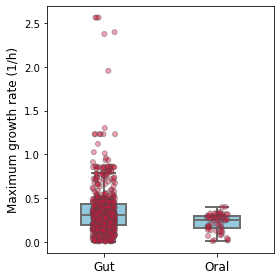

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

_ = sns.boxplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                width=0.4, color="skyblue", linewidth=2, showfliers=False
               )
_ = sns.stripplot(x="is_oral", y="max_growth_rate", data=df_growth, ax=ax,
                  color="crimson", linewidth=1, alpha=0.4
                 )
_ = ax.set_xticklabels(['Gut','Oral'], fontsize=12)
_ = ax.set_xlabel('')
_ = ax.set_ylabel('Maximum growth rate (1/h)', fontsize=12)

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("gut_oral_bact_growth_rate.svg", dpi=600, bbox_inches='tight')

# Parameters

In [7]:
alpha_o = 3.10e5 # oral-gut transmission rate
K_o = 1.39e9 # carrying capacity of oral bacteria, cfu/g
K_g = 2.92e10 # carrying capacity of gut bacteria, cfu/g
gamma_o = 0.23 # maximum growth rate of oral bacteria, 1/h
gamma_g = 0.35 # maximum growht rate of gut bacteria, 1/h
D = 0.08 # fecal excretion rate, 1/h

# Model

In [8]:
def glv(y, t, eps_o, eps_g, tstop):
    B_o, B_g = y
    if t <= tstop:
        epsilon_o_prime = eps_o
        epsilon_g_prime = eps_g
    else:
        epsilon_o_prime = 1
        epsilon_g_prime = 1
    dydt = [
        alpha_o + gamma_o * (1-B_o/K_o-B_g/K_g) * B_o * epsilon_o_prime - D*B_o,
                  gamma_g * (1-B_o/K_o-B_g/K_g) * B_g * epsilon_g_prime - D*B_g
    ]
    return dydt

# Plot gut and oral bacterial loads over time (vary both epsilon_o and epsilon_g)

In [22]:
epsilon_o = np.linspace(0,1,11)
epsilon_g = np.linspace(0,1,11)
tend = 100 # simulation time

In [23]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Gutf'] = 1-df2['Oralf']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['Epsilon_diff'] = eps_o-eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Gutf,Epsilon_o,Epsilon_g,Epsilon_diff
0,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,0.0,0.0,0.0
1,1.0,1.073106e+07,2.057468e+10,2.058542e+10,0.000521,0.999479,0.0,0.0,0.0
2,2.0,1.020394e+07,1.899283e+10,1.900303e+10,0.000537,0.999463,0.0,0.0,0.0
3,3.0,9.717351e+06,1.753259e+10,1.754231e+10,0.000554,0.999446,0.0,0.0,0.0
4,4.0,9.268169e+06,1.618462e+10,1.619389e+10,0.000572,0.999428,0.0,0.0,0.0


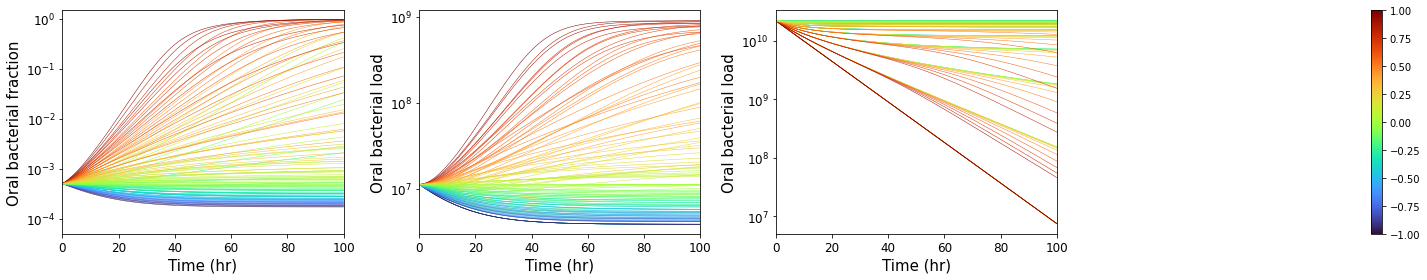

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,4))

# plot trajectory of oral bacterial fraction
palette='turbo'
norm = plt.Normalize(-1,1)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='Oralf', hue='Epsilon_diff', data=curr_df, ax=ax[0], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[0].get_legend() is not None:
            _ = ax[0].get_legend().remove()
_ = ax[0].set_xlim([0,100])
_ = ax[0].set_yscale('log')
_ = ax[0].minorticks_off()
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)
_ = ax[0].set_xlabel('Time (hr)', fontsize=15)
_ = ax[0].set_ylabel('Oral bacterial fraction', fontsize=15)
_ = ax[0].set_ylim([5e-5,1.5])

# plot trajectory of absolute abundance of oral bacteria
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='B_o', hue='Epsilon_diff', data=curr_df, ax=ax[1], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[1].get_legend() is not None:
            _ = ax[1].get_legend().remove()
_ = ax[1].set_xlim([0,100])
_ = ax[1].set_yscale('log')
_ = ax[1].minorticks_off()
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
_ = ax[1].set_xlabel('Time (hr)', fontsize=15)
_ = ax[1].set_ylabel('Oral bacterial load', fontsize=15)
_ = ax[1].set_ylim([3e6,1.2e9])
_ = ax[1].set_yticks([1e7,1e8,1e9])

# plot trajectory of absolute abundance of oral bacteria
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
        _ = sns.lineplot(x="Time", y='B_g', hue='Epsilon_diff', data=curr_df, ax=ax[2], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
        if ax[2].get_legend() is not None:
            _ = ax[2].get_legend().remove()
_ = ax[2].set_xlim([0,100])
_ = ax[2].set_yscale('log')
_ = ax[2].minorticks_off()
_ = ax[2].tick_params(axis='both', which='major', labelsize=12)
_ = ax[2].set_xlabel('Time (hr)', fontsize=15)
_ = ax[2].set_ylabel('Oral bacterial load', fontsize=15)
#_ = ax[2].set_ylim([3e6,1.2e9])
#_ = ax[2].set_yticks([1e7,1e8,1e9])

# plot colorbar
_ = ax[3].figure.colorbar(sm)
_ = ax[3].axis('off')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated_vary_both.svg", dpi=600, bbox_inches='tight')

# Plot gut and oral bacterial load over time (fix_epsilon_g)

In [26]:
epsilon_o = np.linspace(0,1,21)
epsilon_g = 0.1
tend = 100 # simulation time

In [50]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
eps_g = epsilon_g
for eps_o in epsilon_o:
    tspan = np.linspace(0, tend, int(tend)+1)
    sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
    df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
    df2['Loadt'] = df2['B_o']+df2['B_g']
    df2['Oralf'] = df2['B_o']/df2['Loadt']
    df2['Gutf'] = 1-df2['Oralf']
    df2['Epsilon_o'] = eps_o
    df2['log10_Epsilon_o'] = np.log10(eps_o)
    df2['Epsilon_g'] = eps_g
    df2['Epsilon_diff'] = eps_o-eps_g
    if df is None:
        df = deepcopy(df2)
    else:
        df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()

res = []
res2 = []
for B_o_f, B_g_f in zip(df.B_o, df.B_g):
    B_o_i = steady_state[0]
    B_g_i = steady_state[1]
    Oralf_i = B_o_i/(B_o_i+B_g_i)
    Oralf_f = B_o_f/(B_o_f+B_g_f)
    Oralf_fix_Bo = B_o_i/(B_o_i+B_g_f)
    Oralf_fix_Bg = B_o_f/(B_o_f+B_g_i)
    if np.abs(Oralf_fix_Bo-Oralf_f) > np.abs(Oralf_fix_Bg-Oralf_f):
        # expansion
        res.append(0)
        res2.append(-Oralf_fix_Bg/Oralf_f)
    else:
        # marker
        res.append(1)
        res2.append(Oralf_fix_Bo/Oralf_f)
df['Hypothesis'] = res
df['Ratio'] = res2
df.head()

/var/folders/zg/9bd_wdgn3qg8kl1z973r48mjxx5dnb/T/ipykernel_41271/1854069427.py:16: RuntimeWarning: divide by zero encountered in log10
  df2['log10_Epsilon_o'] = np.log10(eps_o)


,Time,B_o,B_g,Loadt,Oralf,Gutf,Epsilon_o,log10_Epsilon_o,Epsilon_g,Epsilon_diff,Hypothesis,Ratio
0,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,0.0,-inf,0.1,-0.1,1,1.000000
1,1.0,1.073106e+07,2.075941e+10,2.077014e+10,0.000517,0.999483,0.0,-inf,0.1,-0.1,1,1.053183
2,2.0,1.020394e+07,1.936950e+10,1.937970e+10,0.000527,0.999473,0.0,-inf,0.1,-0.1,1,1.107556
3,3.0,9.717351e+06,1.810165e+10,1.811137e+10,0.000537,0.999463,0.0,-inf,0.1,-0.1,1,1.162981
4,4.0,9.268169e+06,1.694160e+10,1.695087e+10,0.000547,0.999453,0.0,-inf,0.1,-0.1,1,1.219305


In [51]:
set(df.Hypothesis)

{0, 1}

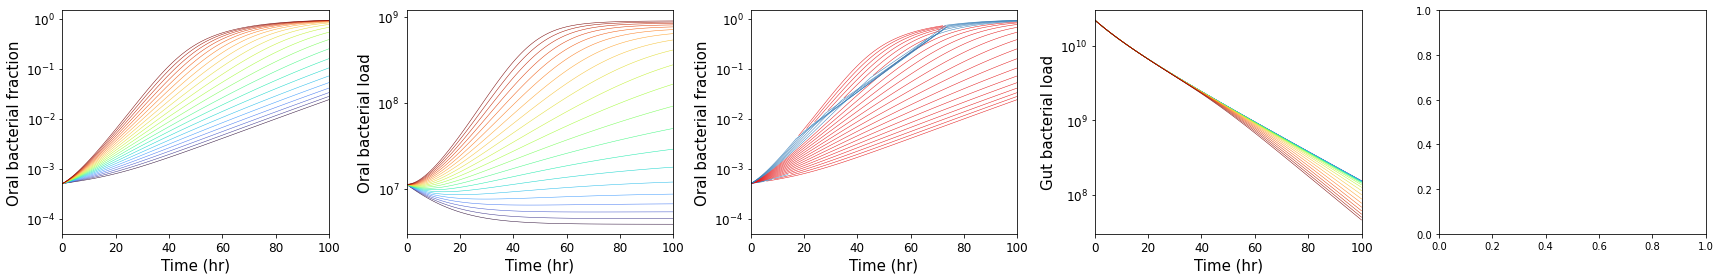

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,4))

# plot trajectory of oral bacterial fraction
palette='turbo'
norm = plt.Normalize(0,1)
sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
sm.set_array([])

palette='turbo'
norm2 = plt.Normalize(-1,1)
sm2 = plt.cm.ScalarMappable(cmap=palette, norm=norm2)
sm2.set_array([])

eps_g = epsilon_g
for eps_o in epsilon_o:
    curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
    _ = sns.lineplot(x="Time", y='Oralf', hue='Epsilon_o', data=curr_df, ax=ax[0], palette=palette, hue_norm=(0,1), zorder=-10, linewidth=0.5)
    if ax[0].get_legend() is not None:
        _ = ax[0].get_legend().remove()
_ = ax[0].set_xlim([0,100])
_ = ax[0].set_yscale('log')
_ = ax[0].minorticks_off()
_ = ax[0].tick_params(axis='both', which='major', labelsize=12)
_ = ax[0].set_xlabel('Time (hr)', fontsize=15)
_ = ax[0].set_ylabel('Oral bacterial fraction', fontsize=15)
_ = ax[0].set_ylim([5e-5,1.5])

# plot trajectory of absolute abundance of oral bacteria
for eps_o in epsilon_o:
    curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
    _ = sns.lineplot(x="Time", y='B_o', hue='Epsilon_o', data=curr_df, ax=ax[1], palette=palette, hue_norm=(0,1), zorder=-10, linewidth=0.5)
    if ax[1].get_legend() is not None:
        _ = ax[1].get_legend().remove()
_ = ax[1].set_xlim([0,100])
_ = ax[1].set_yscale('log')
_ = ax[1].minorticks_off()
_ = ax[1].tick_params(axis='both', which='major', labelsize=12)
_ = ax[1].set_xlabel('Time (hr)', fontsize=15)
_ = ax[1].set_ylabel('Oral bacterial load', fontsize=15)
_ = ax[1].set_ylim([3e6,1.2e9])
_ = ax[1].set_yticks([1e7,1e8,1e9])

# # plot trajectory of gut bacterial fraction
# for eps_o in epsilon_o:
#     curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
#     _ = sns.lineplot(x="Time", y='Gutf', hue='Epsilon_o', data=curr_df, ax=ax[2], palette=palette, hue_norm=(0,1), zorder=-10, linewidth=0.5)
#     if ax[2].get_legend() is not None:
#         _ = ax[2].get_legend().remove()
# _ = ax[2].set_xlim([0,100])
# _ = ax[2].set_yscale('log')
# _ = ax[2].minorticks_off()
# _ = ax[2].tick_params(axis='both', which='major', labelsize=12)
# _ = ax[2].set_xlabel('Time (hr)', fontsize=15)
# _ = ax[2].set_ylabel('Gut bacterial fraction', fontsize=15)
# _ = ax[2].set_ylim([1e-3,1.5])

eps_g = epsilon_g
for eps_o in epsilon_o:
    curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
    _ = sns.lineplot(x="Time", y='Oralf', hue='Hypothesis', data=curr_df, ax=ax[2], palette='Set1', zorder=-10, linewidth=0.5)
    if ax[2].get_legend() is not None:
        _ = ax[2].get_legend().remove()
_ = ax[2].set_xlim([0,100])
_ = ax[2].set_yscale('log')
_ = ax[2].minorticks_off()
_ = ax[2].tick_params(axis='both', which='major', labelsize=12)
_ = ax[2].set_xlabel('Time (hr)', fontsize=15)
_ = ax[2].set_ylabel('Oral bacterial fraction', fontsize=15)
_ = ax[2].set_ylim([5e-5,1.5])

# eps_g = epsilon_g
# for eps_o in epsilon_o:
#     curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
#     _ = sns.scatterplot(x="Time", y='Oralf', hue='Ratio', data=curr_df, ax=ax[2], palette=palette, hue_norm=(-1,1), zorder=-10, linewidth=0.5)
#     if ax[2].get_legend() is not None:
#         _ = ax[2].get_legend().remove()
# _ = ax[2].set_xlim([0,100])
# _ = ax[2].set_yscale('log')
# _ = ax[2].minorticks_off()
# _ = ax[2].tick_params(axis='both', which='major', labelsize=12)
# _ = ax[2].set_xlabel('Time (hr)', fontsize=15)
# _ = ax[2].set_ylabel('Oral bacterial fraction', fontsize=15)
# _ = ax[2].set_ylim([5e-5,1.5])

# plot trajectory of gut bacterial load
for eps_o in epsilon_o:
    curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)]
    _ = sns.lineplot(x="Time", y='B_g', hue='Epsilon_o', data=curr_df, ax=ax[3], palette=palette, hue_norm=(0,1), zorder=-10, linewidth=0.5)
    if ax[3].get_legend() is not None:
        _ = ax[3].get_legend().remove()
_ = ax[3].set_xlim([0,100])
_ = ax[3].set_yscale('log')
_ = ax[3].minorticks_off()
_ = ax[3].tick_params(axis='both', which='major', labelsize=12)
_ = ax[3].set_xlabel('Time (hr)', fontsize=15)
_ = ax[3].set_ylabel('Gut bacterial load', fontsize=15)
_ = ax[3].set_ylim([3e7,3e10])
_ = ax[3].set_yticks([1e8,1e9,1e10])

# plot colorbar
# _ = ax[4].figure.colorbar(sm)
# _ = ax[4].axis('off')
#_ = ax[4].figure.colorbar(sm2)
#_ = ax[4].axis('off')

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("simulated__eps_0.1.svg", dpi=600, bbox_inches='tight')

# Plot oral load for a variety of Eo and Eg

In [19]:
epsilon_o = np.linspace(0,1,5)
epsilon_g = np.linspace(0,1,5)
tend = 100 # simulation time

In [20]:
epsilon_o

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [21]:
# get steady state before any perturbation
sol = odeint(glv, [0.1,0.1], np.linspace(0,2000,100), args=(1,1,tend))
steady_state = list(sol[-1])

# add perturbations
df = None
for eps_o in epsilon_o:
    for eps_g in epsilon_g:
        tspan = np.linspace(0, tend, int(tend)+1)
        sol = odeint(glv, steady_state, tspan, args=(eps_o, eps_g, tend))
        df2 = pd.DataFrame(sol, index=tspan, columns=['B_o','B_g'])
        df2['Loadt'] = df2['B_o']+df2['B_g']
        df2['Oralf'] = df2['B_o']/df2['Loadt']
        df2['Gutf'] = 1-df2['Oralf']
        df2['Epsilon_o'] = eps_o
        df2['Epsilon_g'] = eps_g
        df2['Epsilon_diff'] = eps_o-eps_g
        if df is None:
            df = deepcopy(df2)
        else:
            df = pd.concat([df,df2])
df.index.name='Time'
df = df.reset_index()
df.head()

,Time,B_o,B_g,Loadt,Oralf,Gutf,Epsilon_o,Epsilon_g,Epsilon_diff
0,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,0.0,0.0,0.0
1,1.0,1.073106e+07,2.057468e+10,2.058542e+10,0.000521,0.999479,0.0,0.0,0.0
2,2.0,1.020394e+07,1.899283e+10,1.900303e+10,0.000537,0.999463,0.0,0.0,0.0
3,3.0,9.717351e+06,1.753259e+10,1.754231e+10,0.000554,0.999446,0.0,0.0,0.0
4,4.0,9.268169e+06,1.618462e+10,1.619389e+10,0.000572,0.999428,0.0,0.0,0.0


In [23]:
curr_df

,Time,B_o,B_g,Loadt,Oralf,Gutf,Epsilon_o,Epsilon_g,Epsilon_diff
2424,0.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2425,1.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2426,2.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2427,3.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2428,4.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2520,96.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2521,97.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2522,98.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0
2523,99.0,1.130208e+07,2.228829e+10,2.229959e+10,0.000507,0.999493,1.0,1.0,0.0


0 0 0.3430775956473389
0 1 0.34307759451151476
0 2 0.3430775897226777
0 3 0.34307759193171306
0 4 0.3430775920784369
1 0 1.1083626035381202
1 1 0.8235664885647608
1 2 0.5121344924033236
1 3 0.4400677282100854
1 4 0.4109979972021594
2 0 17.69697377079376
2 1 5.763532983072208
2 2 0.98097042763098
2 3 0.6139948574682939
2 4 0.5129424968683923
3 0 64.9290413551187
3 1 46.013101424790776
3 2 3.0843309149759532
3 3 0.9948732540934062
3 4 0.6817604801131987
4 0 80.31213501784391
4 1 75.98832653047077
4 2 15.29460152258114
4 3 2.0632661611967
4 4 0.9999999999927466


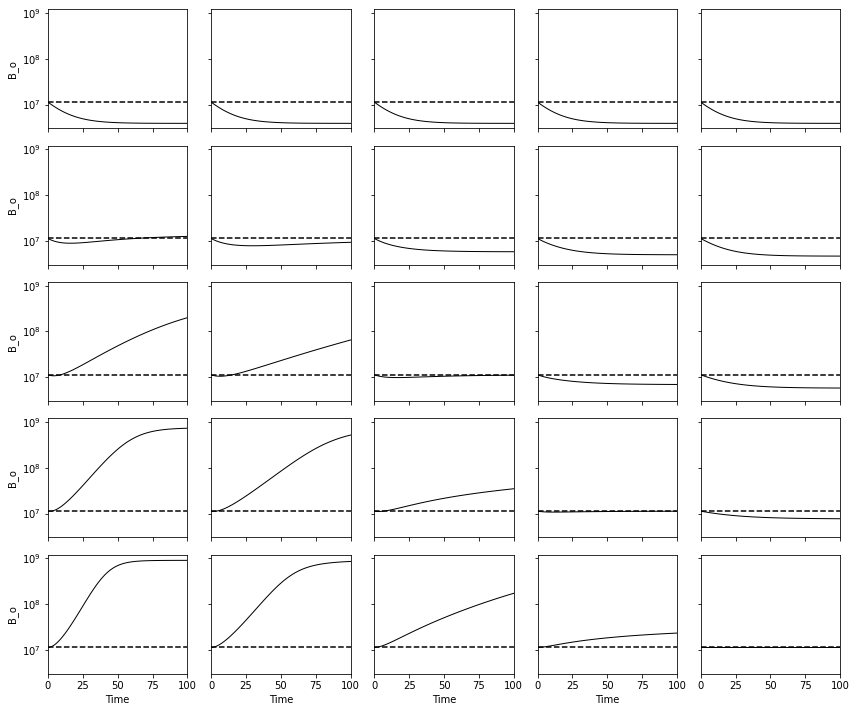

In [36]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(12,10), sharex=True, sharey=True)

for i,eps_o in enumerate(epsilon_o):
    for j,eps_g in enumerate(epsilon_g):
        curr_df = df[(df.Epsilon_o==eps_o) & (df.Epsilon_g==eps_g)].sort_values('Time')
        #if np.abs(list(curr_df.B_o)[-1]-list(curr_df.B_o)[0])/list(curr_df.B_o)[0]<0.25:
        #if np.abs(np.log2(list(curr_df.B_o)[-1]/list(curr_df.B_o)[0]))<1:
        print(i,j,list(curr_df.B_o)[-1]/list(curr_df.B_o)[0])
        _ = sns.lineplot(x="Time", y='B_o', data=curr_df, ax=ax[i,j], zorder=-10, linewidth=1, color='k')
        _ = ax[i,j].plot([0,100],[steady_state[0],steady_state[0]],'k--')
        if ax[i,j].get_legend() is not None:
            _ = ax[i,j].get_legend().remove()
_ = ax[i,j].set_xlim([0,100])
_ = ax[i,j].set_yscale('log')
_ = ax[i,j].minorticks_off()
_ = ax[i,j].set_xlabel('', fontsize=15)
_ = ax[i,j].set_ylabel('', fontsize=15)
_ = ax[i,j].set_ylim([3e6,1.2e9])

plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("grid_search_oral_load.svg", dpi=600, bbox_inches='tight')